In [3]:
!gdown --id 1nPw071R3tZi4zqVcmXA6kXVTe43Ex6K3 --output london_bike_sharing.csv

C:\Users\jongb\anaconda3\lib\site-packages\gdown\cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1nPw071R3tZi4zqVcmXA6kXVTe43Ex6K3
To: C:\Users\jongb\Stat_quest\london_bike_sharing.csv

  0%|          | 0.00/1.03M [00:00<?, ?B/s]
 51%|#####     | 524k/1.03M [00:00<00:00, 2.61MB/s]
100%|##########| 1.03M/1.03M [00:00<00:00, 4.43MB/s]


In [84]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

In [85]:
df = pd.read_csv(
  "london_bike_sharing.csv",
  parse_dates=['timestamp'],
  index_col="timestamp"
)

In [86]:
df.shape

(17414, 9)

In [87]:
df.head(5)

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [77]:
###Feature Engineering

In [88]:
df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

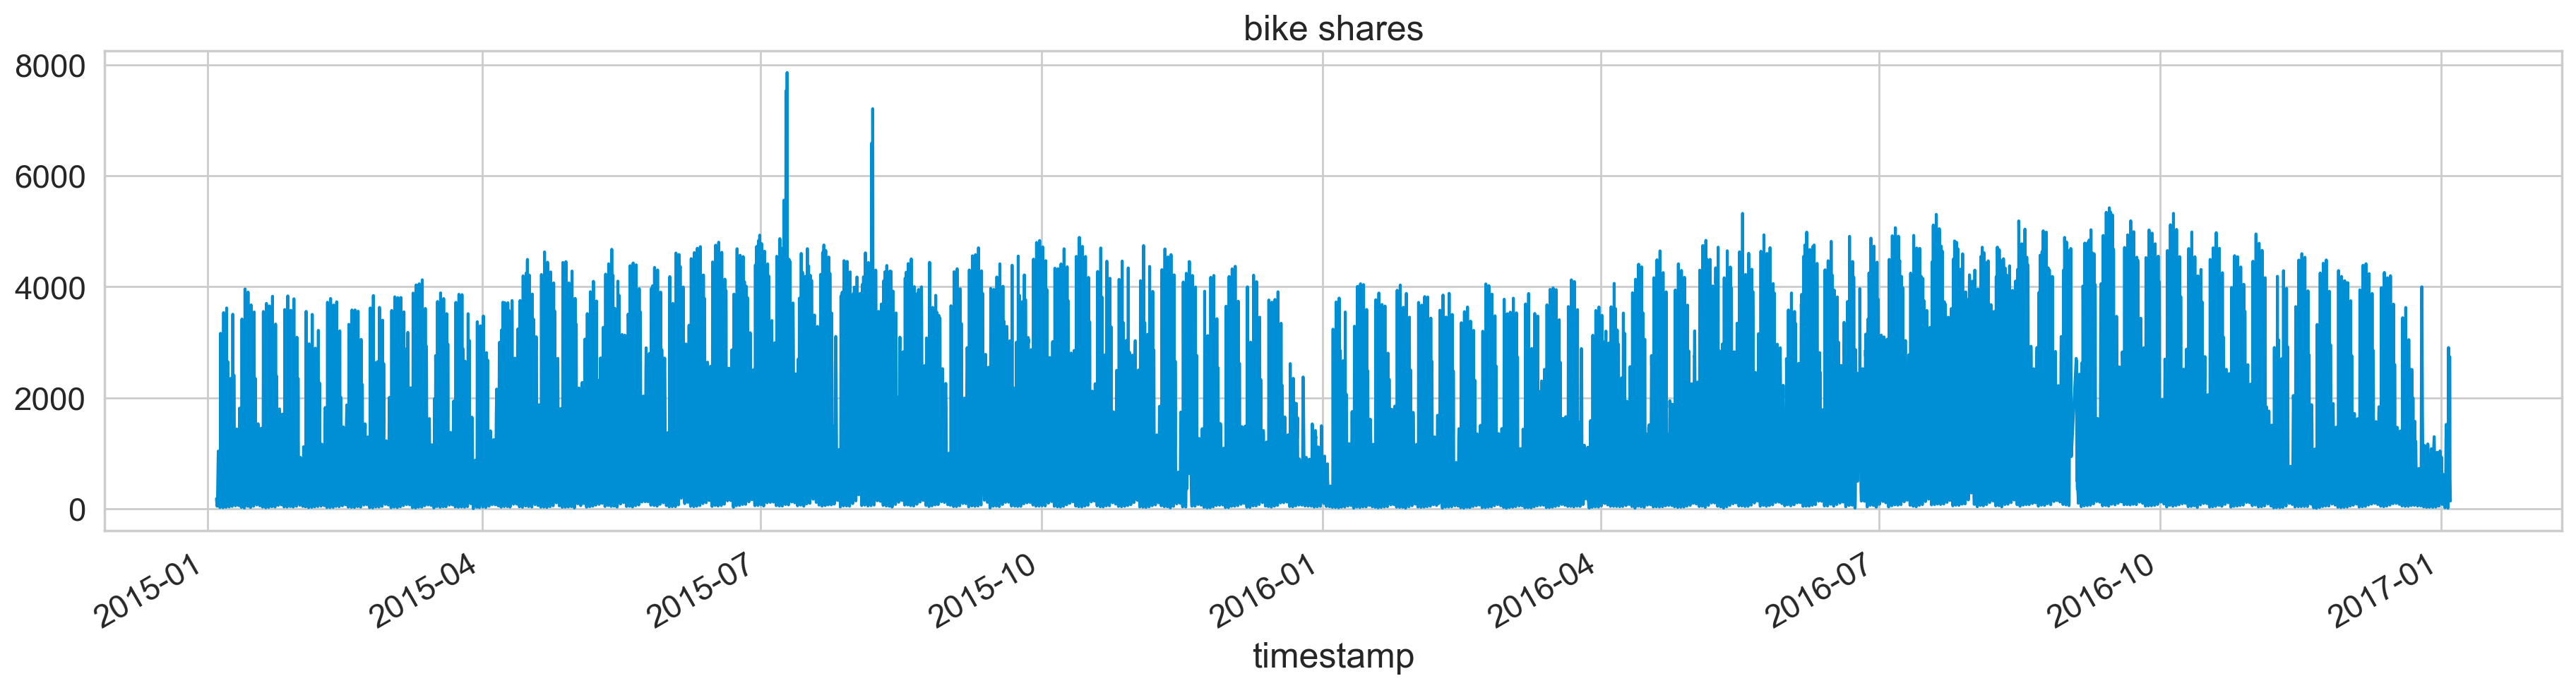

In [89]:
df['cnt'].plot(style='',
        figsize=(20, 5),
        color=color_pal[0],
        title='bike shares')
plt.show()

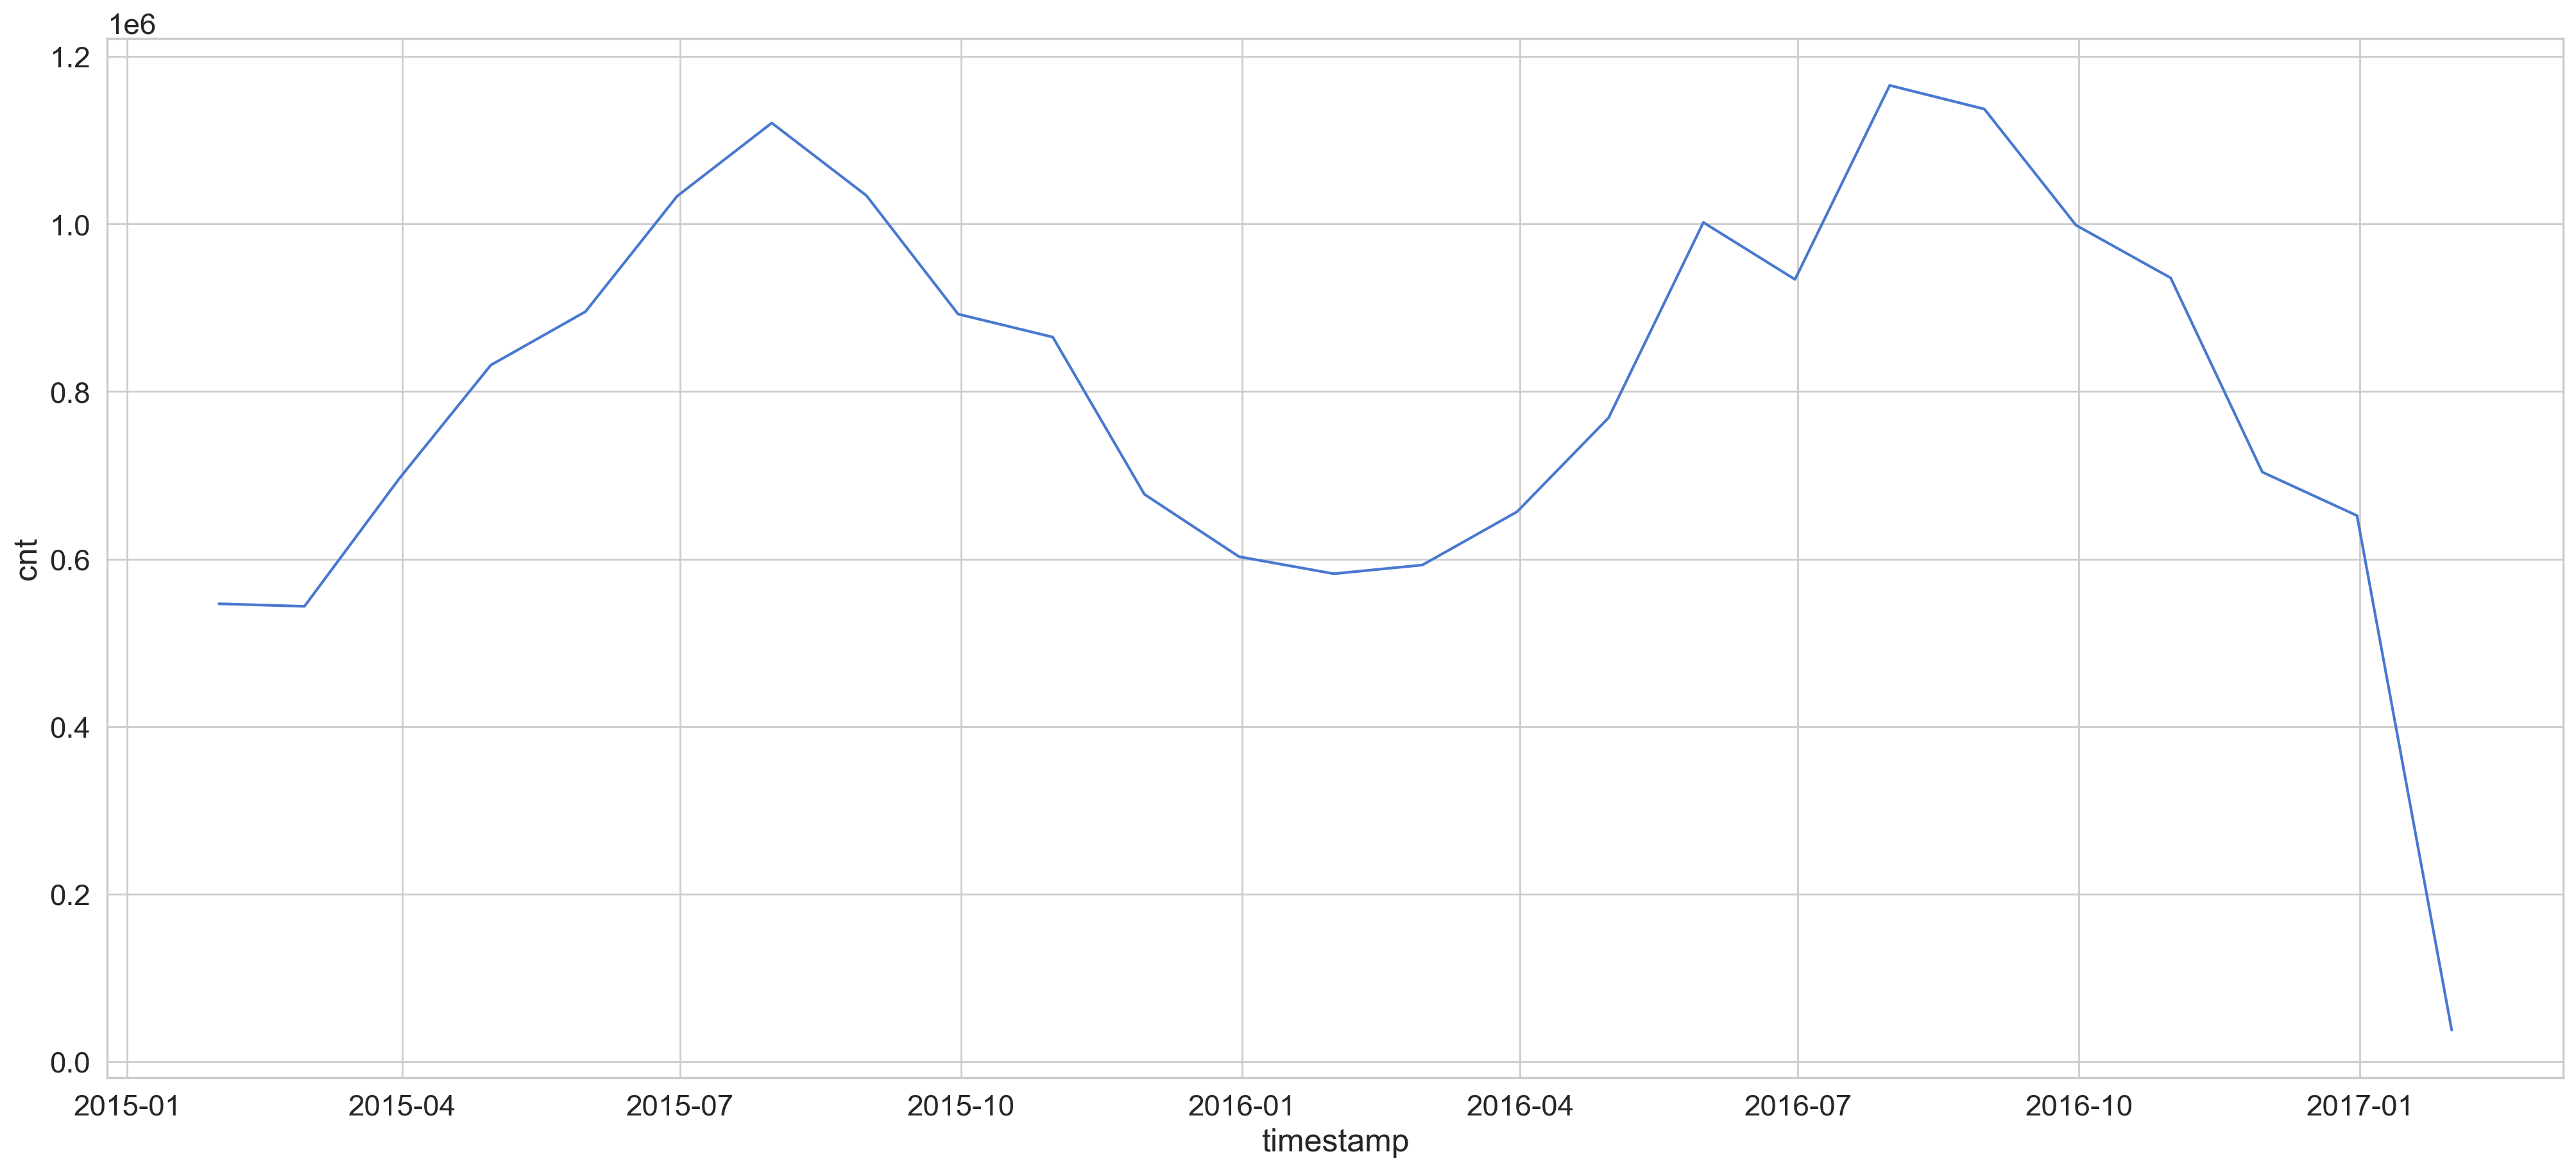

In [90]:
df_by_month = df.resample('M').sum()

sns.lineplot(x=df_by_month.index, y="cnt", data=df_by_month);

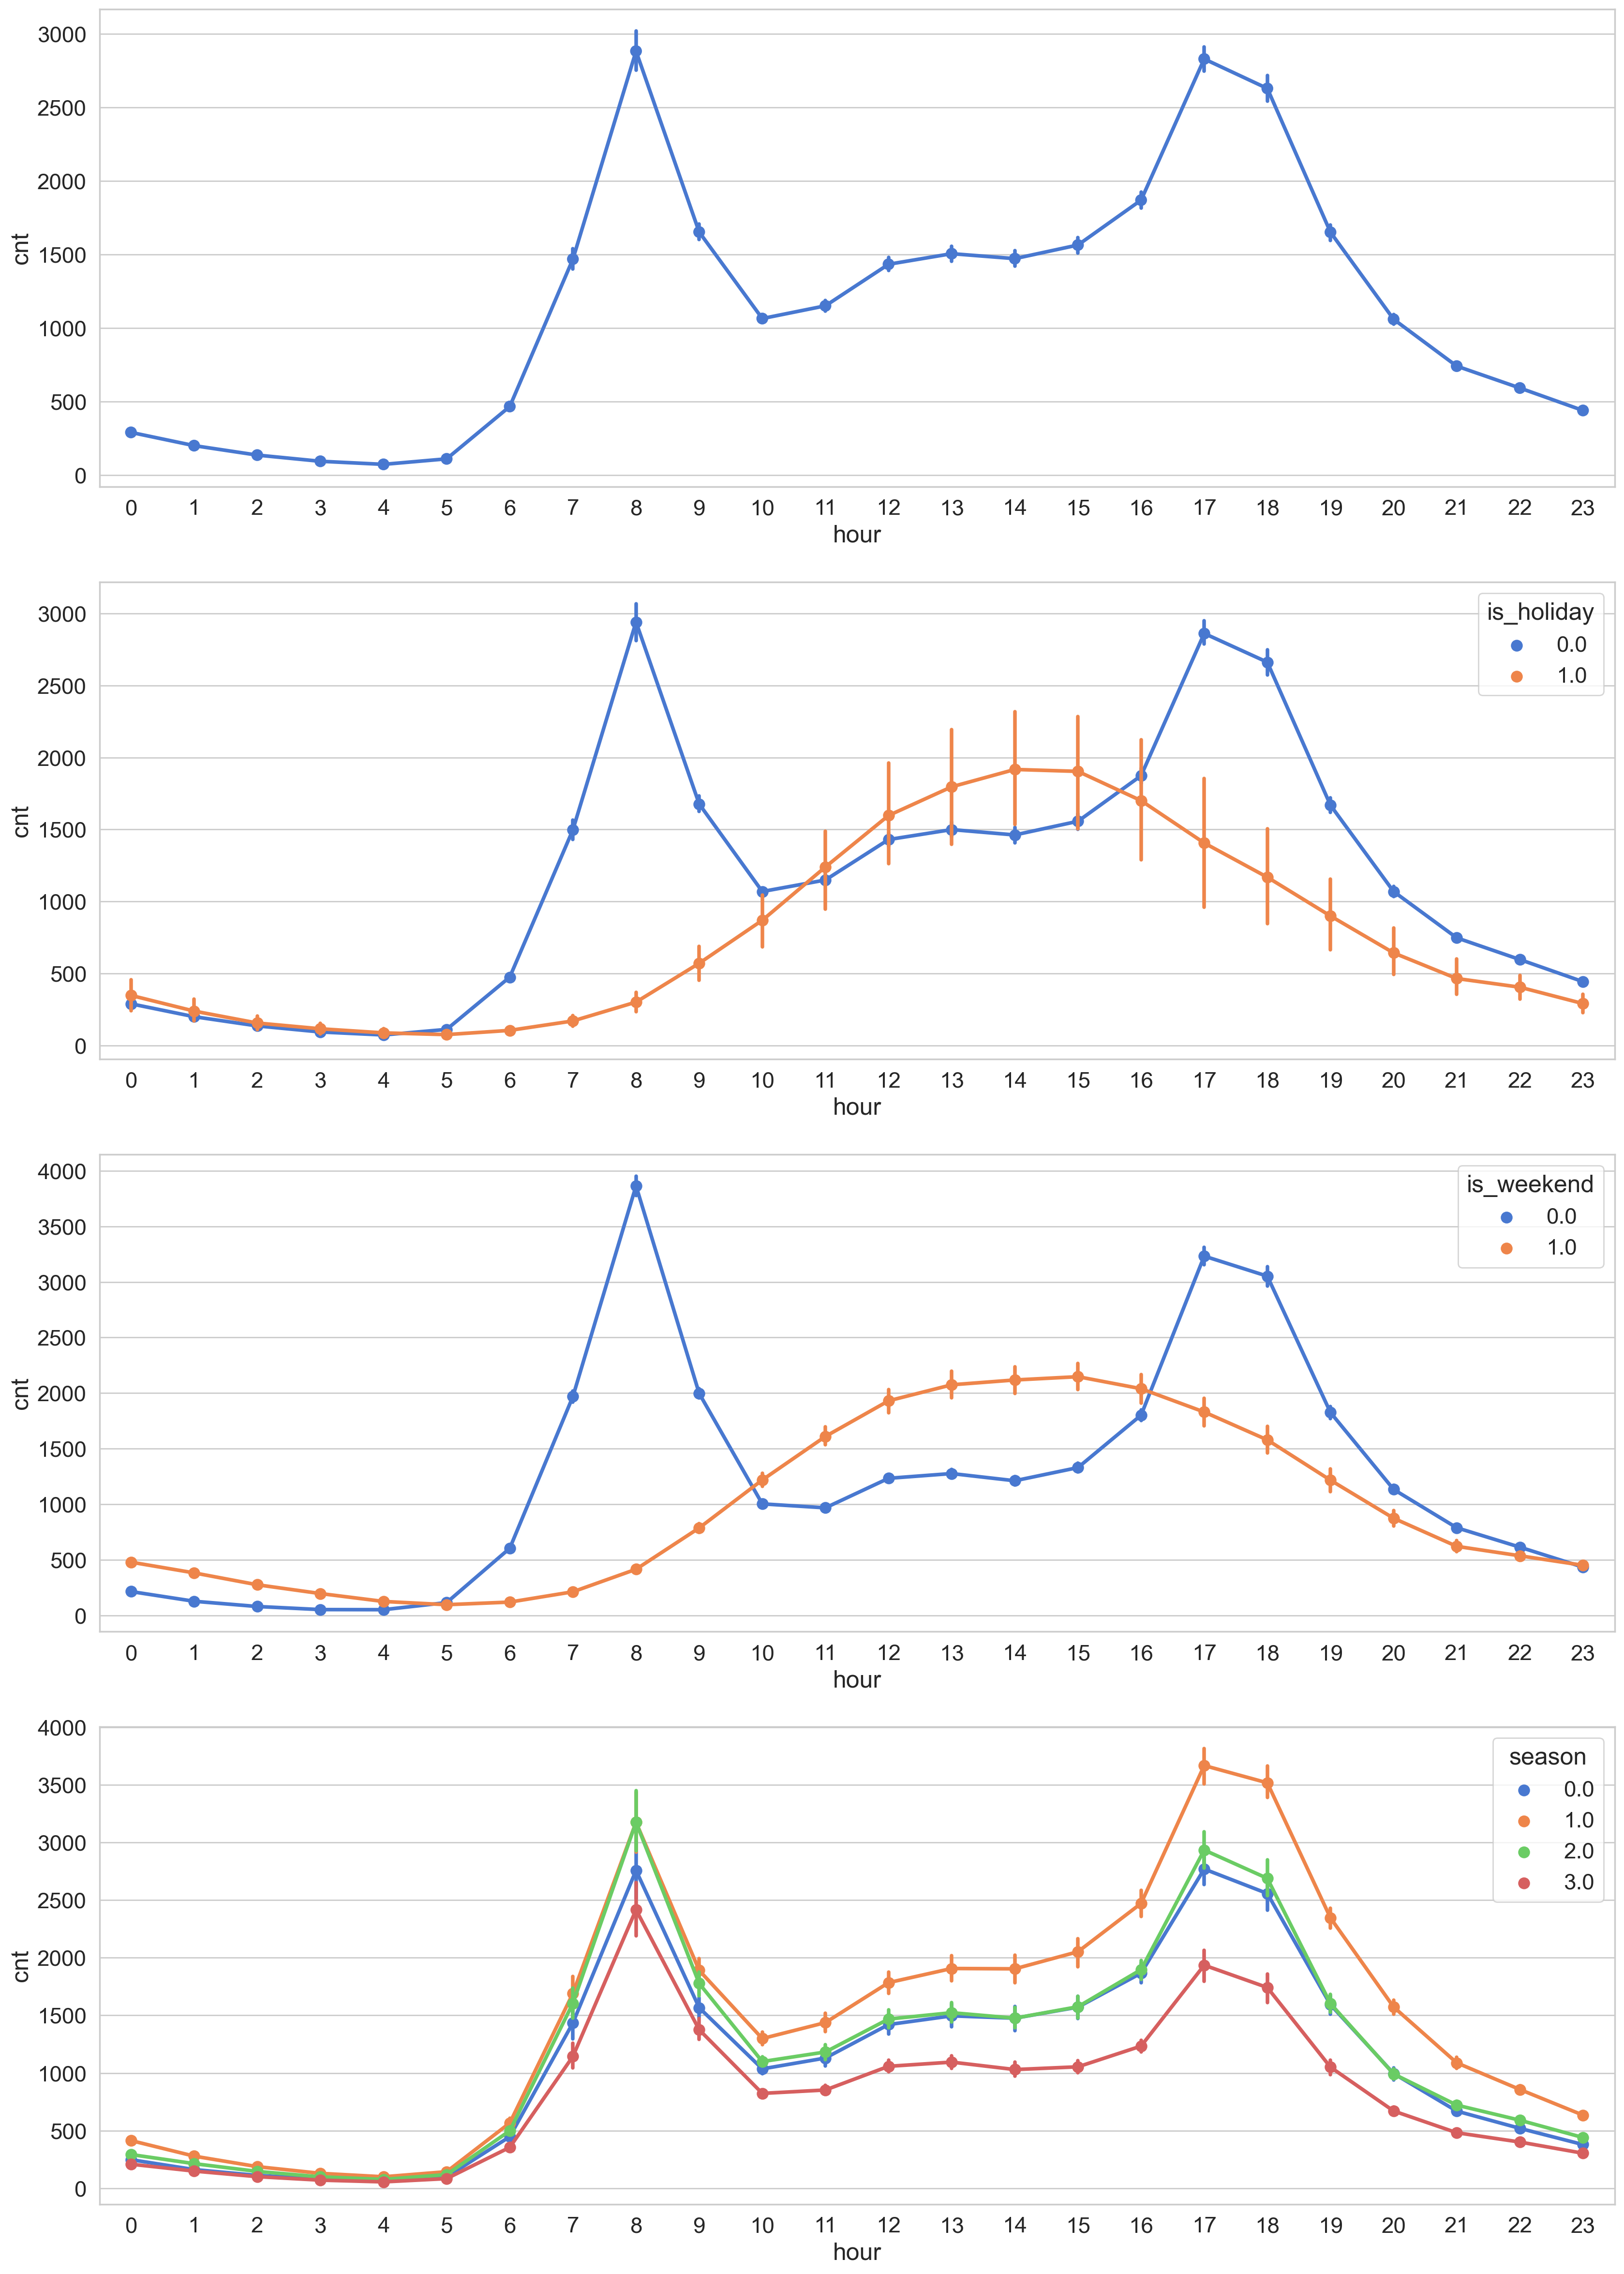

In [91]:
fig,(ax1, ax2, ax3, ax4)= plt.subplots(nrows=4)
fig.set_size_inches(18, 28)

sns.pointplot(data=df, x='hour', y='cnt', ax=ax1)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_holiday', ax=ax2)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_weekend', ax=ax3)
sns.pointplot(data=df, x='hour', y='cnt', hue='season', ax=ax4);
     

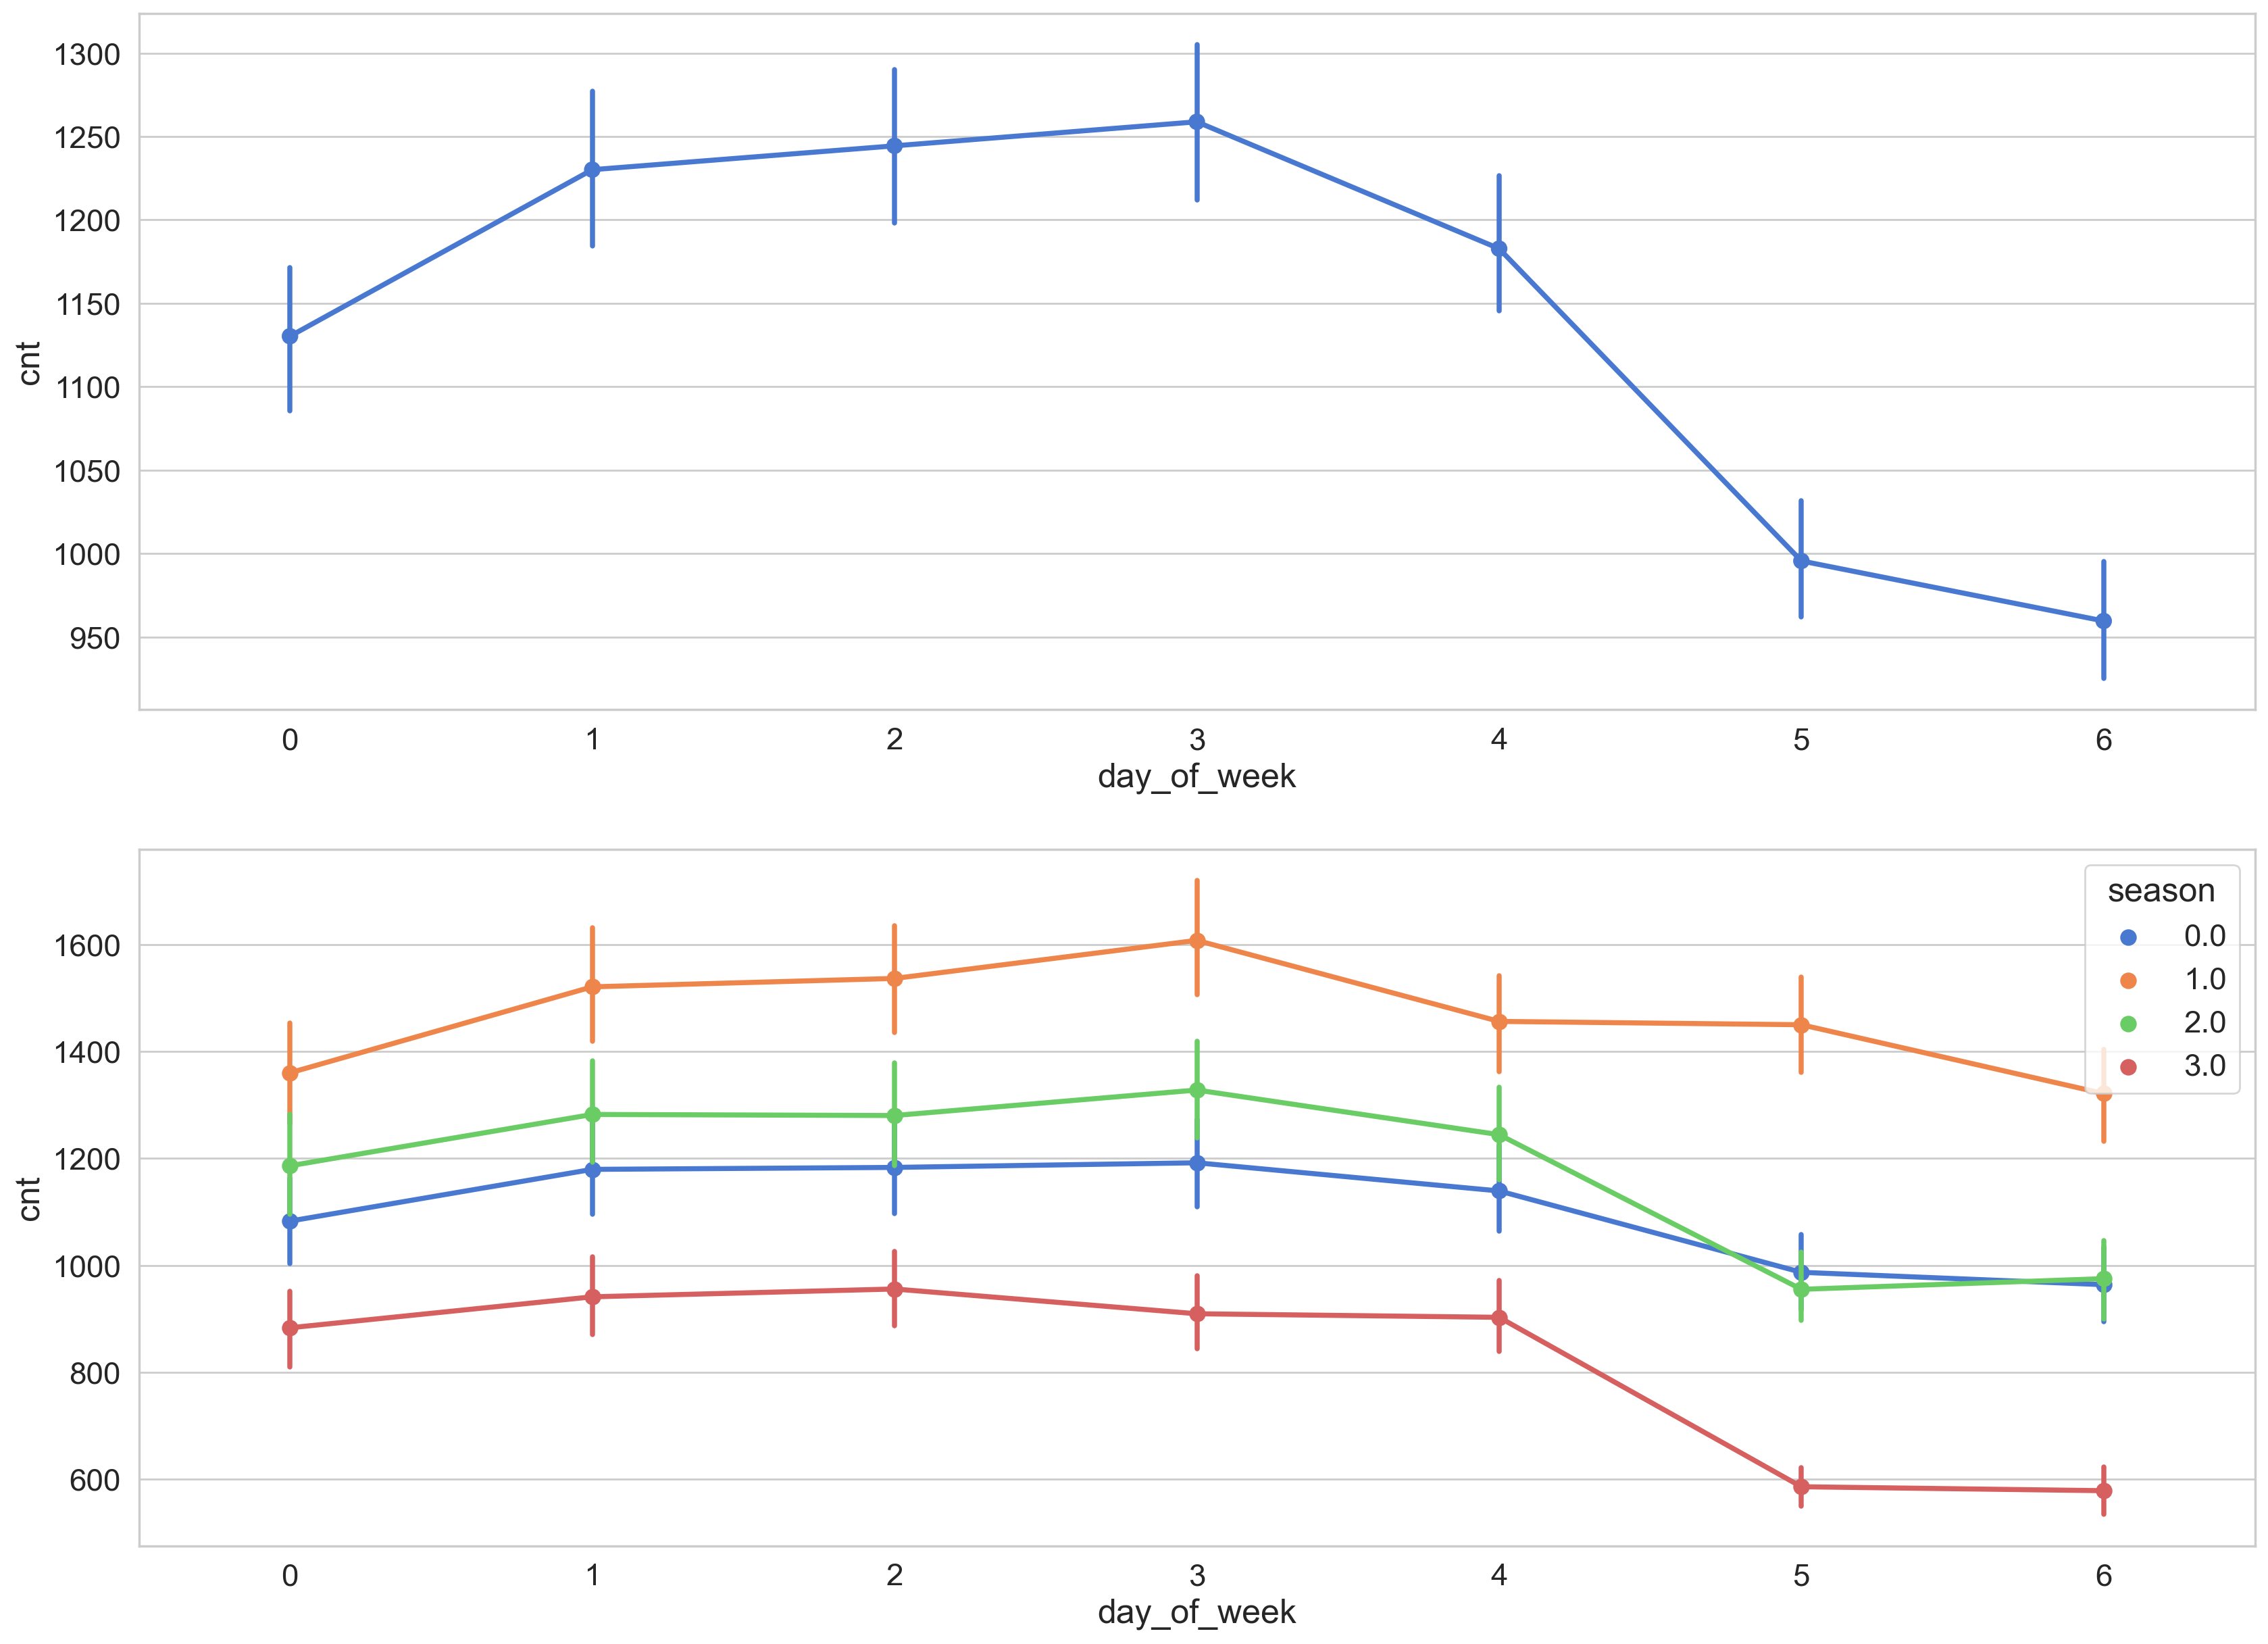

In [92]:
fig,(ax1, ax2)= plt.subplots(nrows=2)
fig.set_size_inches(18, 14)

sns.pointplot(data=df, x='day_of_week', y='cnt', ax=ax1)
sns.pointplot(data=df, x='day_of_week', y='cnt', hue='season', ax=ax2);
     

In [93]:
# Spliting dataset into training and test

train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

15672 1742


In [94]:
###Preprocessing

In [95]:
## Scaling features
from sklearn.preprocessing import RobustScaler

f_columns = ['t1', 't2', 'hum', 'wind_speed']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['cnt']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['cnt'] = cnt_transformer.transform(train[['cnt']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['cnt'] = cnt_transformer.transform(test[['cnt']])
     


C:\Users\jongb\AppData\Local\Temp\ipykernel_23212\332901153.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
C:\Users\jongb\AppData\Local\Temp\ipykernel_23212\332901153.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['cnt'] = cnt_transformer.transform(train[['cnt']])
C:\Users\jongb\AppData\Local\Temp\ipykernel_23212\332901153.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [ ]:
### Prepare Sequence

In [96]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [97]:
time_steps = 10

# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train, train.cnt, time_steps)

X_test, y_test = create_dataset(test, test.cnt, time_steps)

print(X_train.shape, y_train.shape)

(15662, 10, 13) (15662,)


In [68]:
### Build the model: LSTM 
# One layer with Dropout Layer
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [69]:
model = keras.Sequential()

model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=128,input_shape=(X_train.shape[1], X_train.shape[2]))))

model.add(keras.layers.Dropout(rate=0.2))

model.add(keras.layers.Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [70]:
# Fit Model

history = model.fit(X_train, y_train,epochs=30, batch_size=32, validation_split=0.1, shuffle=False)

Epoch 1/30
441/441 [==============================] - 6s 10ms/step - loss: 0.2527 - val_loss: 0.1625
Epoch 2/30
441/441 [==============================] - 4s 9ms/step - loss: 0.0905 - val_loss: 0.0607
Epoch 3/30
441/441 [==============================] - 4s 9ms/step - loss: 0.0514 - val_loss: 0.0429
Epoch 4/30
441/441 [==============================] - 4s 10ms/step - loss: 0.0372 - val_loss: 0.0386
Epoch 5/30
441/441 [==============================] - 4s 9ms/step - loss: 0.0327 - val_loss: 0.0365
Epoch 6/30
441/441 [==============================] - 4s 9ms/step - loss: 0.0271 - val_loss: 0.0316
Epoch 7/30
441/441 [==============================] - 4s 9ms/step - loss: 0.0255 - val_loss: 0.0325
Epoch 8/30
441/441 [==============================] - 4s 9ms/step - loss: 0.0224 - val_loss: 0.0357
Epoch 9/30
441/441 [==============================] - 4s 9ms/step - loss: 0.0222 - val_loss: 0.0319
Epoch 10/30
441/441 [==============================] - 4s 9ms/step - loss: 0.0218 - val_loss: 0.03

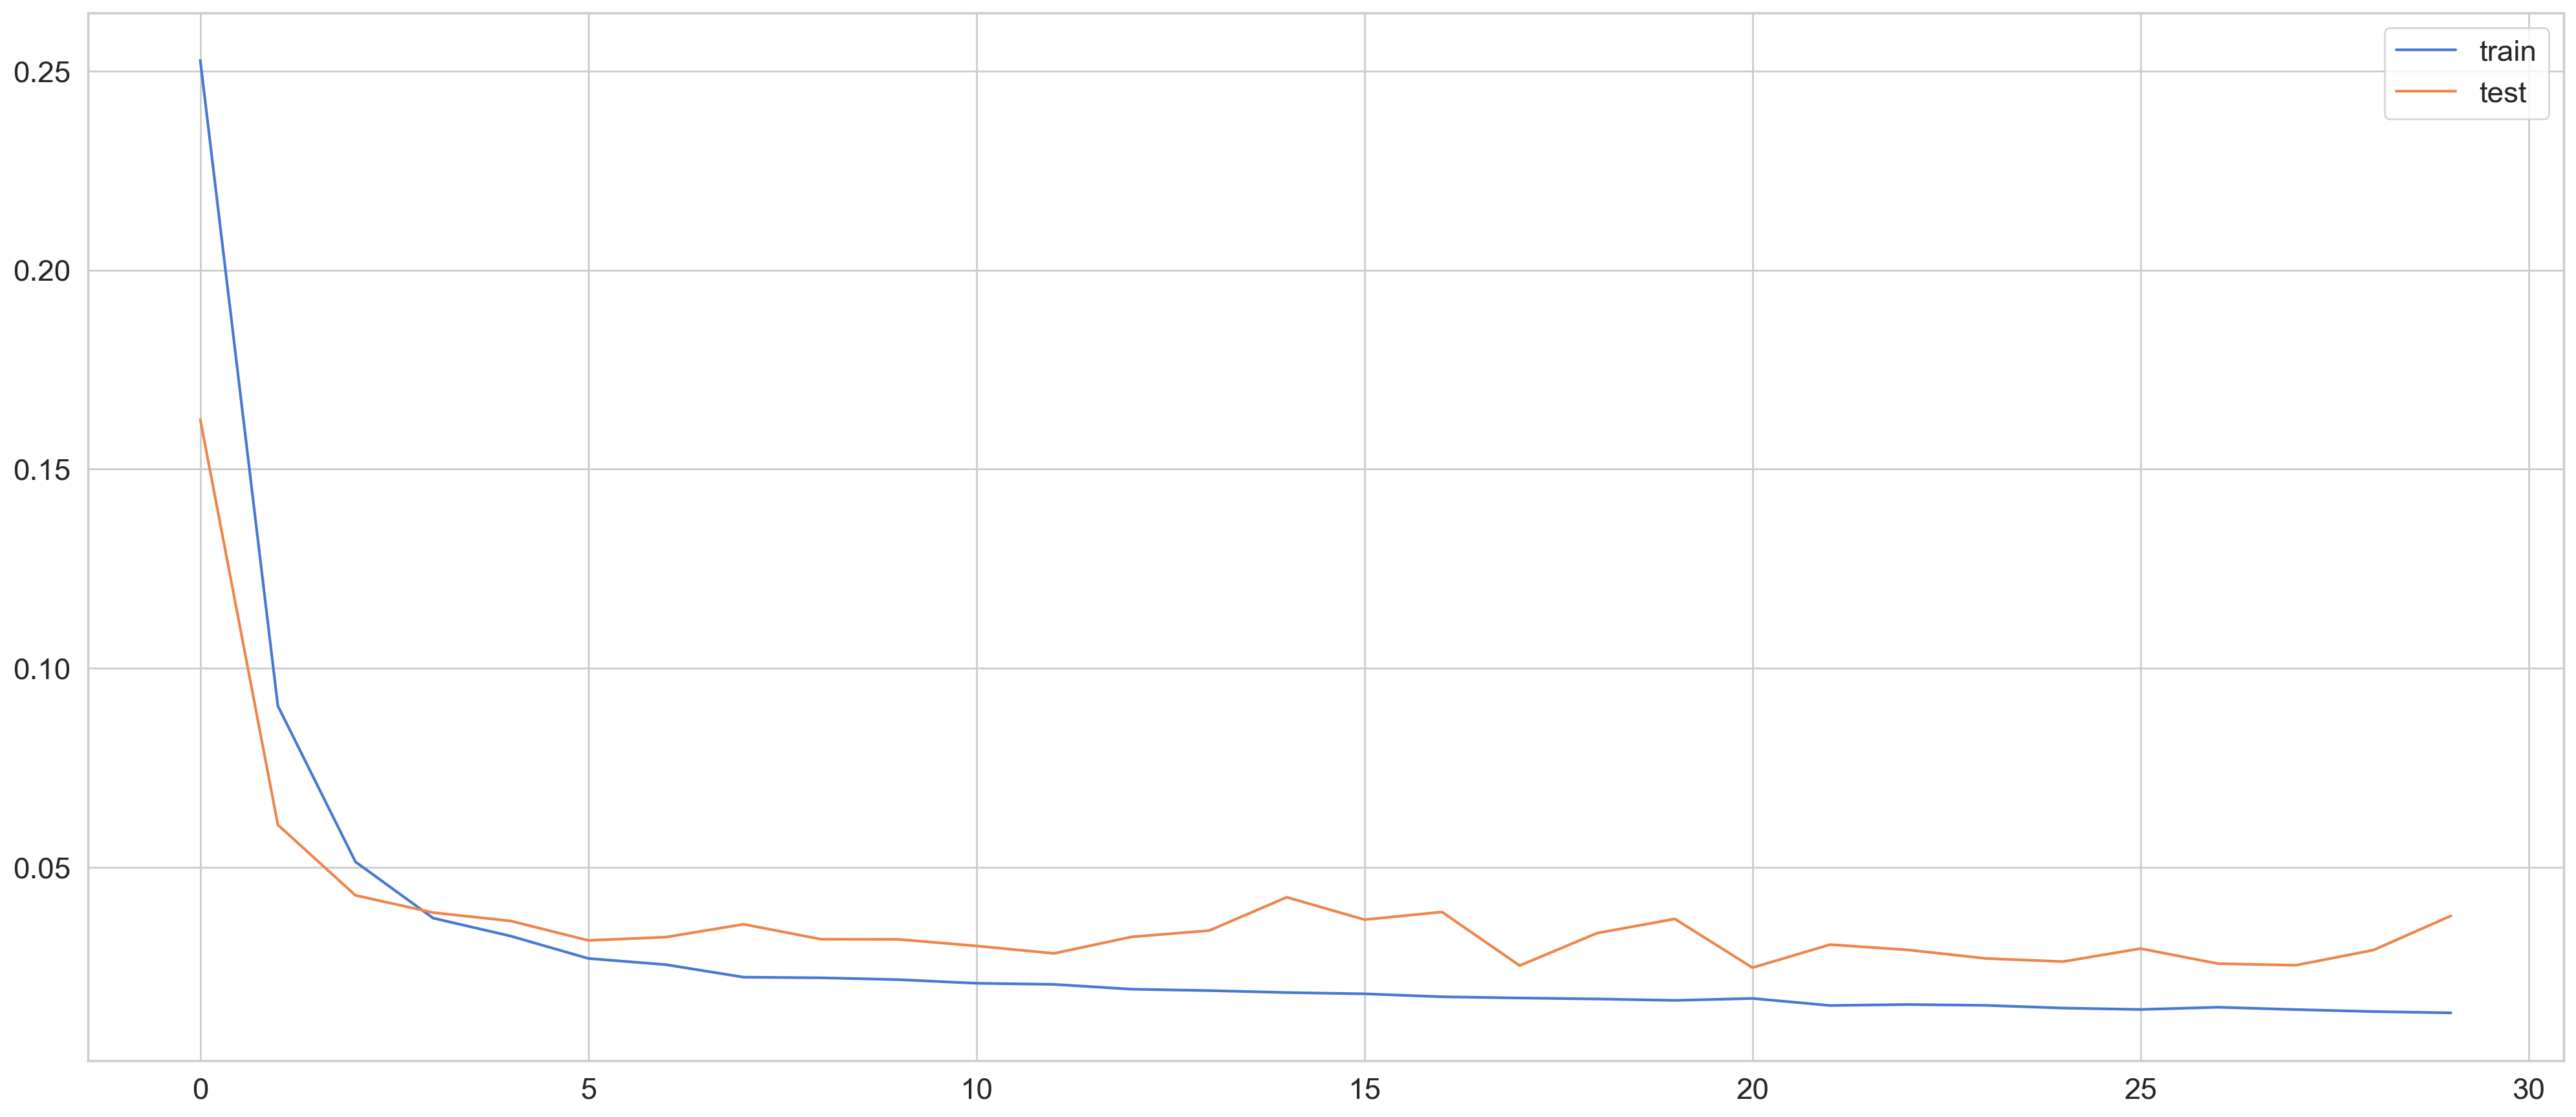

In [98]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [101]:
### Prediction using test datset

y_pred = model.predict(X_test)

55/55 [==============================] - 1s 3ms/step


In [102]:
#inverse variables

y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

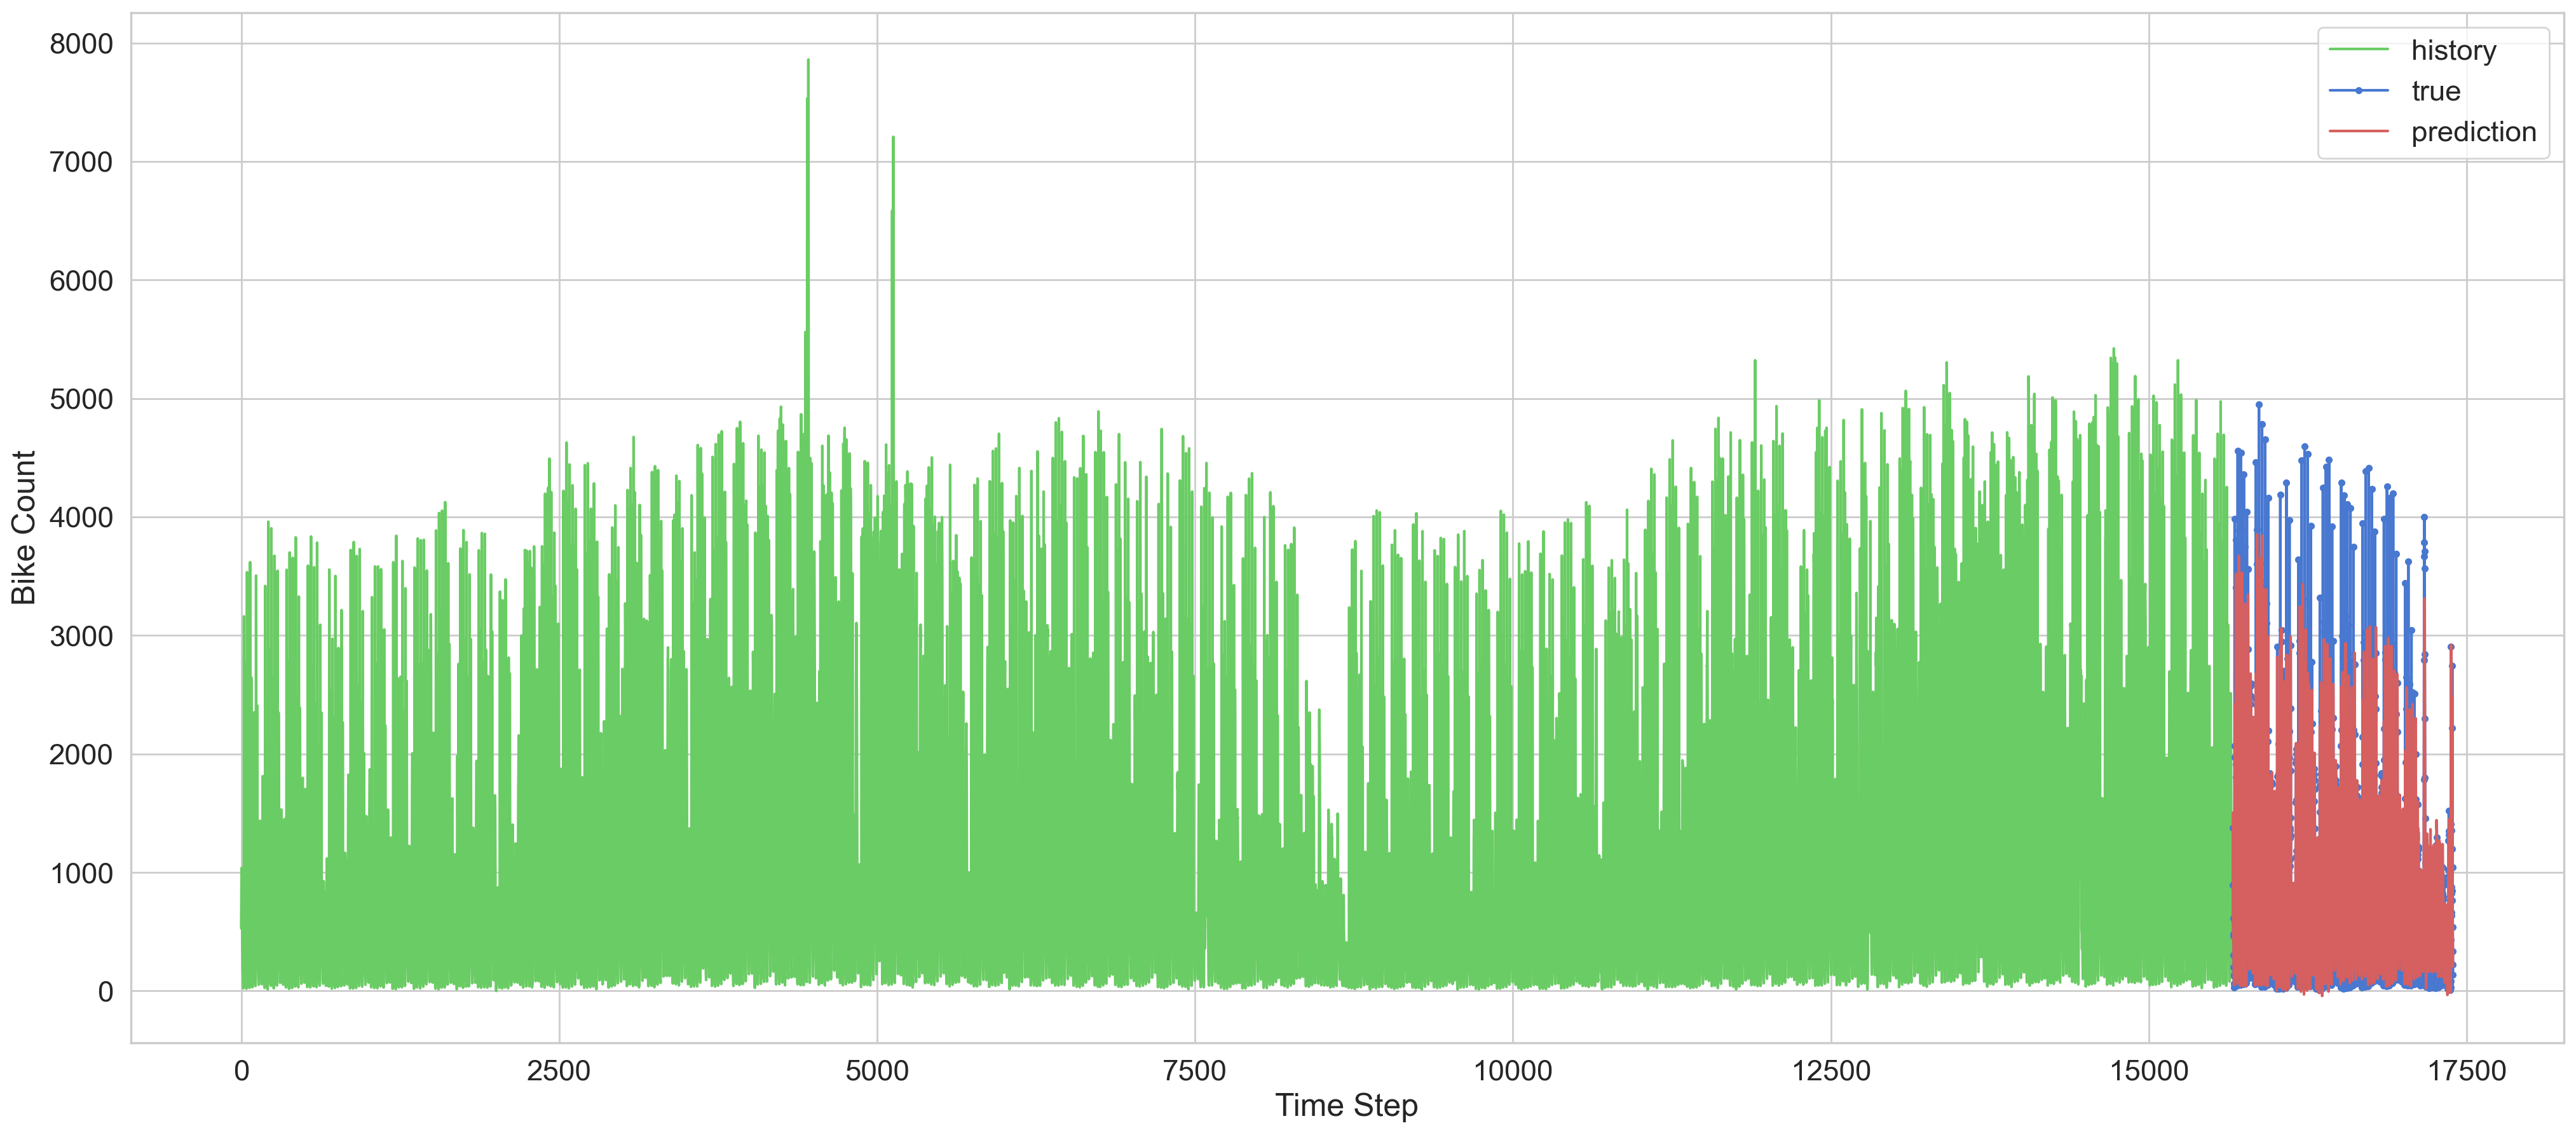

In [103]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

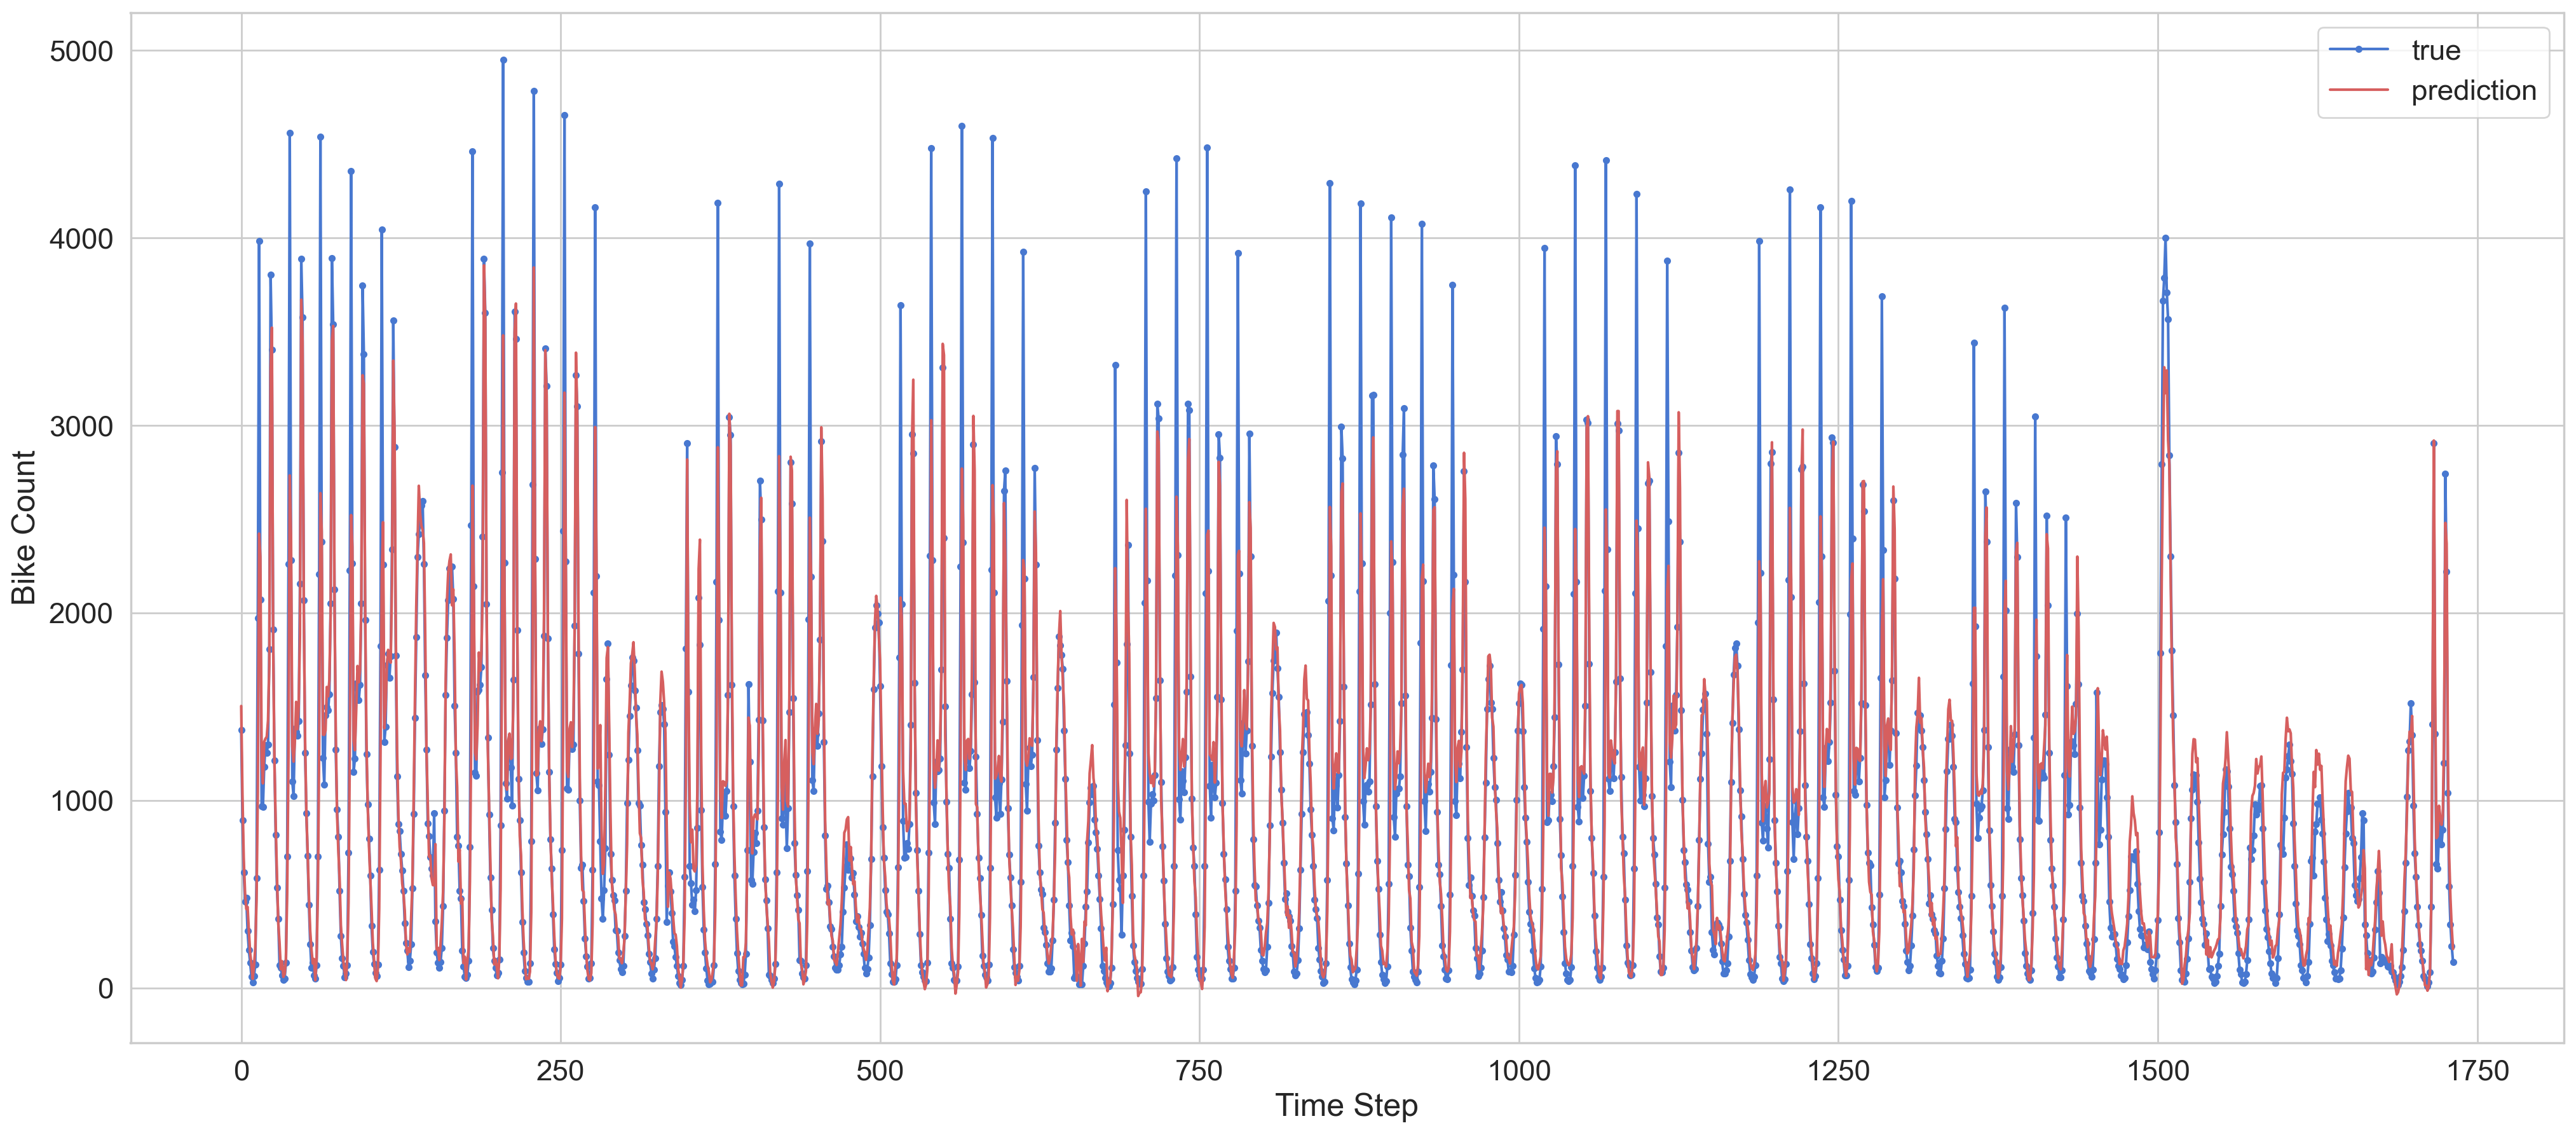

In [104]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();